# Analysing models

This notebook analyses the result of the model testing performed in `testing-models.ipynb`. The models are evaluated based on the following metrics:
- Accuracy - here we call it the error rate
- Precision
- Recall

## Step 0: Setup

In [155]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Set up R in jupyter notebook and import the tidyverse package so we can plot the data using ggplot2.

In [157]:
%%R

require('tidyverse')

And load in the data

In [158]:
df = pd.read_csv('model_outputs.csv')

## Step 1: Clean and reshape the data for analysis

Before starting the analysis, I want to figure out how many of the rows have substantial comments in them. 

I define substantial as comments over 20 characters. For those rows, I set set the column `substantial_text` to `True`. If the `full_text` column is `None` or contains less than 20 characters, `substantial_text` is set to `False`.

In [159]:
df['substantial_text'] = df['full_text'].apply(lambda x: False if pd.isnull(x) or len(x) < 20 else True)

Drop of all the columns in df starting with ai_response

In [160]:
df = df.drop(columns=[col for col in df.columns if col.startswith('ai_response')])

### Reshape data from wide to long

Define a function to extract the model name from the column names

In [161]:
def extract_model_name(column_name):
    parts = column_name.split('_')
    if parts[0] == 'verification':
        # Join parts excluding the 'verification' and the category
        return '_'.join(parts[2:])
    else:
        # Join parts excluding the category
        return '_'.join(parts[1:])

Define a function to extract the category name from the column names

In [162]:
def extract_category_name(column_name):
    return column_name.split('_')[0]

Melt the DataFrame for model predictions

In [163]:
df_melted = df.melt(id_vars=['agency_id', 'docket_id', 'comment_id', 'full_text', 'substantial_text'],
                     var_name='combined', value_name='value')

Extract model and category from the combined column

In [164]:
df_melted['model'] = df_melted['combined'].apply(extract_model_name)
df_melted['category'] = df_melted['combined'].apply(extract_category_name)

Filter out the verification rows into a separate DataFrame and rename columns in verification DataFrame for clarity and later merge

In [165]:
df_verification = df_melted[df_melted['category'] == 'verification'].copy()
df_verification.rename(columns={'value': 'verification_value'}, inplace=True)

Drop the verification rows from the melted DataFrame

In [166]:
df_melted = df_melted[df_melted['category'] != 'verification']

Merge the verification DataFrame back into the melted DataFrame

In [167]:
df_final = pd.merge(df_melted, df_verification,
                    on=['agency_id', 'docket_id', 'comment_id', 'full_text', 'substantial_text', 'model'],
                    how='left')

In [168]:
# drop the columns combined_x, combined_y, 	category_x, category_y
df_final = df_final.drop(columns=['combined_x', 'combined_y', 'category_x', 'category_y'])

Split the model name into model and category by the last '_'

and the model name is the part before the last '_'

In [169]:
df_final['category'] = df_final['model'].apply(lambda x: x.rsplit('_', 1)[0])
df_final['model'] = df_final['model'].apply(lambda x: x.rsplit('_',2)[-1])

In [170]:
# drop rows where model is equal to category
df_final = df_final[df_final['model'] != df_final['category']]

# and where model is name or region
df_final = df_final[~df_final['model'].isin(['name', 'region'])]

In [171]:
df_final

,agency_id,docket_id,comment_id,full_text,substantial_text,value,model,verification_value,category
0,ATF,ATF-2023-0002,ATF-2023-0002-369205,Gun Owners of America has informed me that ATF...,True,The commenter expresses concerns about the ATF...,claude-3-haiku-20240307,True positive,summary
1,FMCSA,FMCSA-2023-0236,FMCSA-2023-0236-0030,The Commercial Vehicle Training Association (...,True,The Commercial Vehicle Training Association (C...,claude-3-haiku-20240307,True positive,summary
2,FWS,FWS-R1-ES-2022-0074,FWS-R1-ES-2022-0074-0539,I am writing as someone who feels particularly...,True,The commenter expresses their concern for the ...,claude-3-haiku-20240307,True positive,summary
3,IRS,IRS-2023-0066,IRS-2023-0066-6646,Thank you for issuing this strong guidance tha...,True,The commenter expresses their support for the ...,claude-3-haiku-20240307,True positive,summary
4,APHIS,APHIS-2015-0093,APHIS-2015-0093-7823,As someone who cares deeply about deer and hum...,True,The commenter urges Wildlife Services to revis...,claude-3-haiku-20240307,True positive,summary
...,...,...,...,...,...,...,...,...,...
17395,IRS,IRS-2023-0066,IRS-2023-0066-21379,Thank you for your leadership in implementing ...,True,NaN,gpt-4-1106-preview,True negative,zip
17396,NHTSA,NHTSA-2023-0022,NHTSA-2023-0022-47344,"Federal Register CAFƒ Standards Comments, We ...",True,98225,gpt-4-1106-preview,True positive,zip
17397,ATF,ATF-2023-0002,ATF-2023-0002-271677,"Dear Attorney General Garland, I strongly sup...",True,7044,gpt-4-1106-preview,True positive,zip
17398,BLM,BLM-2023-0006,BLM-2023-0006-75719,"Dear Bureau of Land Management, I am opposed ...",True,NaN,gpt-4-1106-preview,True negative,zip


## Step 2: Analyze the data

Now that the data is in the right shape, I can start asking questions some essential questions of the data:
- What are the share of `False negative` and `False positive` predictions for each model?
- Does `False negative` and `False positive` predictions vary by category?
- Are `False negative` often the result of a lack of substantial text?

### 2.1 Calculate error rates

In [172]:
df_final.head()

,agency_id,docket_id,comment_id,full_text,substantial_text,value,model,verification_value,category
0,ATF,ATF-2023-0002,ATF-2023-0002-369205,Gun Owners of America has informed me that ATF...,True,The commenter expresses concerns about the ATF...,claude-3-haiku-20240307,True positive,summary
1,FMCSA,FMCSA-2023-0236,FMCSA-2023-0236-0030,The Commercial Vehicle Training Association (...,True,The Commercial Vehicle Training Association (C...,claude-3-haiku-20240307,True positive,summary
2,FWS,FWS-R1-ES-2022-0074,FWS-R1-ES-2022-0074-0539,I am writing as someone who feels particularly...,True,The commenter expresses their concern for the ...,claude-3-haiku-20240307,True positive,summary
3,IRS,IRS-2023-0066,IRS-2023-0066-6646,Thank you for issuing this strong guidance tha...,True,The commenter expresses their support for the ...,claude-3-haiku-20240307,True positive,summary
4,APHIS,APHIS-2015-0093,APHIS-2015-0093-7823,As someone who cares deeply about deer and hum...,True,The commenter urges Wildlife Services to revis...,claude-3-haiku-20240307,True positive,summary


In [173]:
verification_counts = df_final.groupby(['model', 'category', 'verification_value'])['comment_id'].count().reset_index(name='verification_count')
total_counts = df_final.groupby(['model', 'category'])['comment_id'].count().reset_index(name='total_count')
error_rate_grouped = pd.merge(verification_counts, total_counts, on=['model', 'category'])
error_rate_grouped['error_rate'] = error_rate_grouped['verification_count'] / error_rate_grouped['total_count'] * 100

In [174]:
error_rate_grouped.head()

,model,category,verification_value,verification_count,total_count,error_rate
0,claude-3-haiku-20240307,address,False negative,1,200,0.5
1,claude-3-haiku-20240307,address,False positive,5,200,2.5
2,claude-3-haiku-20240307,address,True negative,174,200,87.0
3,claude-3-haiku-20240307,address,True positive,20,200,10.0
4,claude-3-haiku-20240307,city,False negative,2,200,1.0


### 2.2 Overall error rate for each model

In [175]:
error_rate = error_rate_grouped.groupby(['model', 'verification_value'])['verification_count'].sum() / error_rate_grouped.groupby(['model'])['verification_count'].sum() * 100
error_rate = error_rate.reset_index(name='error_rate')

Check if all error rates add up to 100% for each model.

In [176]:
error_rate.groupby('model')['error_rate'].sum()

model
claude-3-haiku-20240307     100.0
claude-3-opus-20240229      100.0
claude-3-sonnet-20240229    100.0
gemini-1.0-pro              100.0
gpt-3.5-turbo-1106          100.0
gpt-4-1106-preview          100.0
Name: error_rate, dtype: float64

In [177]:
false = error_rate[error_rate['verification_value'].isin(['False negative', 'False positive'])]
false = false.groupby('model')['error_rate'].sum().reset_index()

In [178]:
false

,model,error_rate
0,claude-3-haiku-20240307,6.194690
1,claude-3-opus-20240229,3.076923
2,claude-3-sonnet-20240229,3.230769
3,gemini-1.0-pro,5.194306
4,gpt-3.5-turbo-1106,14.769231
5,gpt-4-1106-preview,3.116583


#### 2.2.1: Plot

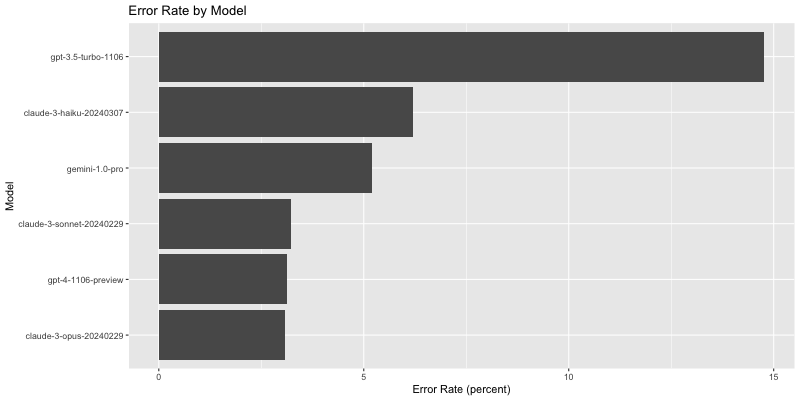

In [179]:
%%R -i false -w 800 -h 400

plt <- ggplot(false, aes(y=reorder(model, error_rate), x=error_rate)) +
    geom_col(stat='identity', position='dodge') +
    labs(title='Error Rate by Model', x='Error Rate (percent)', y='Model') 

plt

### 2.2.2: Precision and recall for each model


https://en.wikipedia.org/wiki/Precision_and_recall

Precision: how many of the retrieved items are relevant

$$presicion = tp / (tp + fp)$$

Recall: how many of the relevant items are retrieved

$$recall = tp / (tp + fn)$$

#### Precision

In [180]:
precision = error_rate[error_rate['verification_value'].isin(['True positive', 'False positive'])]
precision = precision.groupby(['model', 'verification_value'])['error_rate'].sum() / precision.groupby(['model'])['error_rate'].sum() * 100
precision = precision.reset_index(name='precision')
precision = precision[precision['verification_value'] == 'True positive']

In [181]:
precision

,model,verification_value,precision
1,claude-3-haiku-20240307,True positive,88.217968
3,claude-3-opus-20240229,True positive,97.882736
5,claude-3-sonnet-20240229,True positive,93.975904
7,gemini-1.0-pro,True positive,98.351648
9,gpt-3.5-turbo-1106,True positive,82.325581
11,gpt-4-1106-preview,True positive,96.960000


#### Recall

In [182]:
recall = error_rate[error_rate['verification_value'].isin(['True positive', 'False negative'])]
recall = recall.groupby(['model', 'verification_value'])['error_rate'].sum() / recall.groupby(['model'])['error_rate'].sum() * 100
recall = recall.reset_index(name='recall')
recall = recall[recall['verification_value'] == 'True positive']

In [183]:
recall

,model,verification_value,recall
1,claude-3-haiku-20240307,True positive,88.088235
3,claude-3-opus-20240229,True positive,89.970060
5,claude-3-sonnet-20240229,True positive,93.413174
7,gemini-1.0-pro,True positive,80.995475
9,gpt-3.5-turbo-1106,True positive,53.474320
11,gpt-4-1106-preview,True positive,90.718563


In [184]:
# join precision and recall and error_rate
precision_recall = pd.merge(precision, recall, on='model')
precision_recall = pd.merge(precision_recall, false, on='model')

#drop verification_value columns
precision_recall = precision_recall.drop(columns=['verification_value_x', 'verification_value_y'])
precision_recall

,model,precision,recall,error_rate
0,claude-3-haiku-20240307,88.217968,88.088235,6.194690
1,claude-3-opus-20240229,97.882736,89.970060,3.076923
2,claude-3-sonnet-20240229,93.975904,93.413174,3.230769
3,gemini-1.0-pro,98.351648,80.995475,5.194306
4,gpt-3.5-turbo-1106,82.325581,53.474320,14.769231
5,gpt-4-1106-preview,96.960000,90.718563,3.116583


In [185]:
precision_recall.to_csv('accuracy_precision_recall.csv', index=False)

### 2.3 Error rate by category and model
A more detailed look into the balance between `False negative` and `False positive` predictions for each category and model

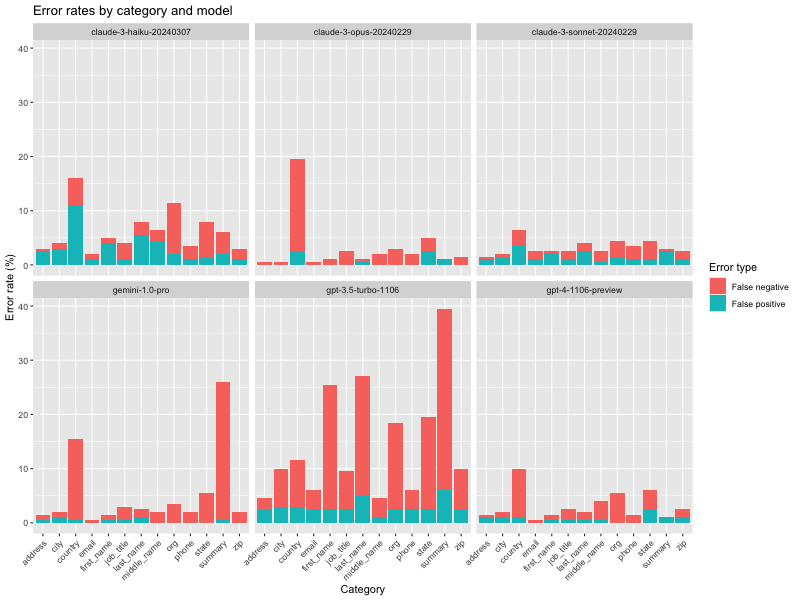

In [186]:
%%R -i error_rate_grouped -w 800 -h 600

# Filter the data down to the False positive and False negative error rates
error_rate_grouped = error_rate_grouped %>%
    filter(verification_value %in% c('False positive', 'False negative'))

# Make a stacked bar chart of the error rates
ggplot(error_rate_grouped, aes(x=category, y=error_rate, fill=verification_value)) +
    geom_bar(stat='identity') +
    facet_wrap(~model) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title='Error rates by category and model', x='Category', y='Error rate (%)', fill='Error type')

### 2.4 False positives

In [187]:
false_positives = df_final.groupby(['model', 'category', 'verification_value', 'substantial_text'])['verification_value'].count() / df_final.groupby(['model', 'category'])['verification_value'].count() * 100
false_positives = false_positives.reset_index(name='error_rate')
false_positives = false_positives[false_positives['verification_value'] == 'False positive']

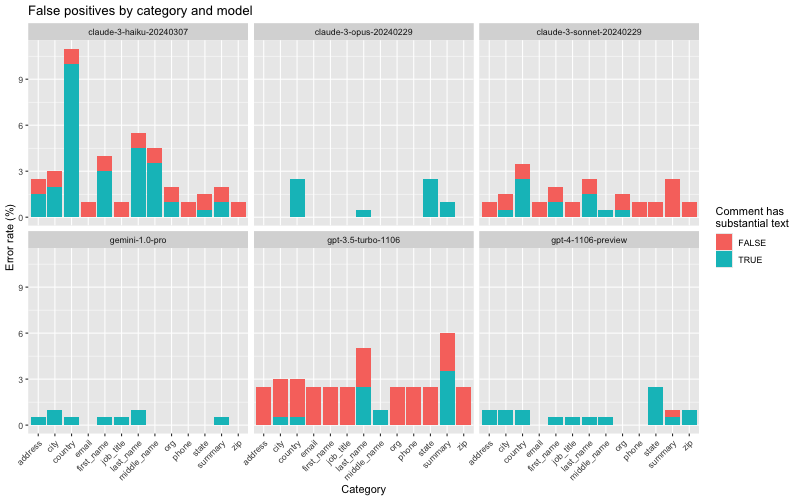

In [188]:
%%R -i false_positives -w 800 -h 500

# Make a stacked bar chart of the error rates
ggplot(false_positives, aes(x=category, y=error_rate, fill=substantial_text)) +
    geom_bar(stat='identity') +
    facet_wrap(~model) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title='False positives by category and model', x='Category', y='Error rate (%)', fill='Comment has \nsubstantial text')

### 2.4 False negatives

In [189]:
false_negatives = df_final.groupby(['model', 'category', 'verification_value'])['verification_value'].count() / df_final.groupby(['model', 'category'])['verification_value'].count() * 100
false_negatives = false_negatives.reset_index(name='error_rate')
false_negatives = false_negatives[false_negatives['verification_value'] == 'False negative']

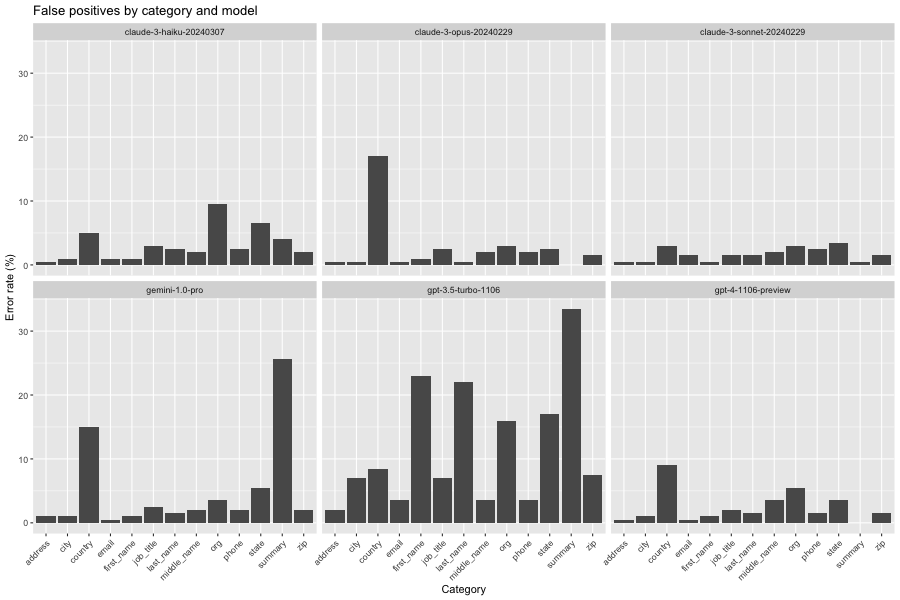

In [190]:
%%R -i false_negatives -w 900 -h 600

# Make a stacked bar chart of the error rates
ggplot(false_negatives, aes(x=category, y=error_rate)) +
    geom_bar(stat='identity') +
    facet_wrap(~model) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title='False positives by category and model', x='Category', y='Error rate (%)')